In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv("../trainingandtestdata/training.1600000.processed.noemoticon.csv", header=None, names=cols, encoding= "ISO-8859–1")
# above line will be different depending on where you saved your data, and your file name

In [2]:
# Remove unecessary columns and focus on sentiment
df.drop(['id','date','query_string','user'],axis=1,inplace=True)
df[df.sentiment == 0].head(10)
df.sentiment.value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

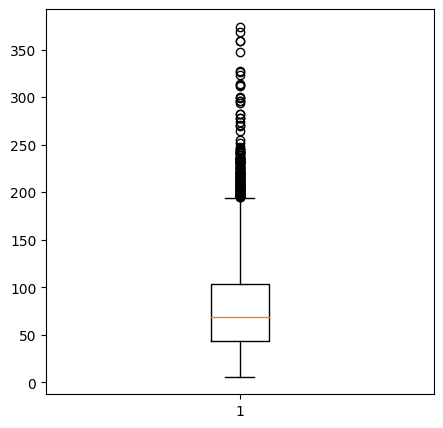

In [5]:
df['pre_clean_len'] = [len(t) for t in df.text]
# Visualizing the overall distribution of length of strings in the tweets
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()
# Strange behavior is shown since max chars should only be 140

In [ ]:
# Identify points where tweets must be cleaned up

In [8]:
# Point 1 - HTML Components
print ("Before:",df.text[279])
from bs4 import BeautifulSoup
example1 = BeautifulSoup(df.text[279], 'html')
example1.get_text()

Before: Whinging. My client&amp;boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&amp;reviewed correctly. 


"Whinging. My client&boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&reviewed correctly. "

In [10]:
# Point 2 - @mentions
print ("Before:",df.text[343])
import re # Use regex matching to eliminate mentions
re.sub(r'@[A-Za-z0-9]+','',df.text[343])

Before: @TheLeagueSF Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down 


' Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [12]:
# Point 3 - URL Links
print("Before:",df.text[0])
# Use char matching to remove any links present in tweet
re.sub('https?://[A-Za-z0-9./]+','',df.text[0])

Before: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


"@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [14]:
# Point 4 - UTF BOM Characters
print("Before:",df.text[226])
df.text[226].replace("ï¿½", "?")

Before: Tuesdayï¿½ll start with reflection ï¿½n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers 


'Tuesday?ll start with reflection ?n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [16]:
# Point 5 - Hashtags #
print("Before:",df.text[175])
re.sub("[^a-zA-Z]", " ", df.text[175])

Before: @machineplay I'm so sorry you're having to go through this. Again.  #therapyfail


' machineplay I m so sorry you re having to go through this  Again    therapyfail'

In [18]:
# Iterate over all the tweets and clean
# Order of cleaning: 1. Souping, 2. BOM removal, 3. URL(http, www) removal, 4. lower-case, 5. negation handling 
# 6. Special Char & number removal, tokenizing
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

# Previously didnt account for different types of URLS that start with "www, http, https, etc."
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
# Previously didnt account for negation in form of contractions. Had to hardcode engine to recognize them in the regex string
# so algorithm would not remove "t" in every contraction or word 
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'html.parser')
    souped = soup.get_text()
    try:
        bom_removed = souped.replace("ï¿½", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # Will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [19]:
nums = [0,400000,800000,1200000,1600000]
print("Cleaning and parsing the tweets...\n")
clean_tweet_texts = []
for i in range(0, 1600000):
    if( (i+1)%10000 == 0 ):
        print ("Tweets %d of %d has been processed" % ( i+1, nums[-1] ))                                                                    
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))

Cleaning and parsing the tweets...



/Users/mystiquant/Documents/Twitter-Sentiment/Twitter_ENV/lib/python3.11/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Tweets 10000 of 1600000 has been processed
Tweets 20000 of 1600000 has been processed
Tweets 30000 of 1600000 has been processed
Tweets 40000 of 1600000 has been processed
Tweets 50000 of 1600000 has been processed
Tweets 60000 of 1600000 has been processed
Tweets 70000 of 1600000 has been processed
Tweets 80000 of 1600000 has been processed
Tweets 90000 of 1600000 has been processed
Tweets 100000 of 1600000 has been processed
Tweets 110000 of 1600000 has been processed
Tweets 120000 of 1600000 has been processed
Tweets 130000 of 1600000 has been processed
Tweets 140000 of 1600000 has been processed
Tweets 150000 of 1600000 has been processed
Tweets 160000 of 1600000 has been processed
Tweets 170000 of 1600000 has been processed
Tweets 180000 of 1600000 has been processed
Tweets 190000 of 1600000 has been processed
Tweets 200000 of 1600000 has been processed
Tweets 210000 of 1600000 has been processed
Tweets 220000 of 1600000 has been processed
Tweets 230000 of 1600000 has been process

In [ ]:
# Format df to be inputted back into a CSV file
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = df.sentiment

clean_df.to_csv('clean_tweet.csv',encoding='utf-8')
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)

In [20]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.info()
my_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1596041 non-null  object
 1   target  1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 36.6+ MB


,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [21]:
# There were no null entries in the original data set, so will be dropping null entries and updating data set
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596041 entries, 0 to 1596040
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1596041 non-null  object
 1   target  1596041 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [22]:
# Calculate the term frequencies of each word in positive and negative tweets
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(my_df.text)

# Differentiate positive and negative by their target
neg_doc_matrix = cvec.transform(my_df[my_df.target == 0].text)
pos_doc_matrix = cvec.transform(my_df[my_df.target == 4].text)
# Sum up the frequencies and arrange into the table
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names_out()).transpose()

In [23]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
to,313162,252567,565729
the,257836,265998,523834
my,190775,125955,316730
it,157448,147786,305234
and,153958,149642,303600
you,103844,198245,302089
not,194724,86865,281589
is,133432,111191,244623
in,115542,101160,216702
for,98999,117369,216368


Text(0.5, 1.0, 'Top 500 tokens in tweets')

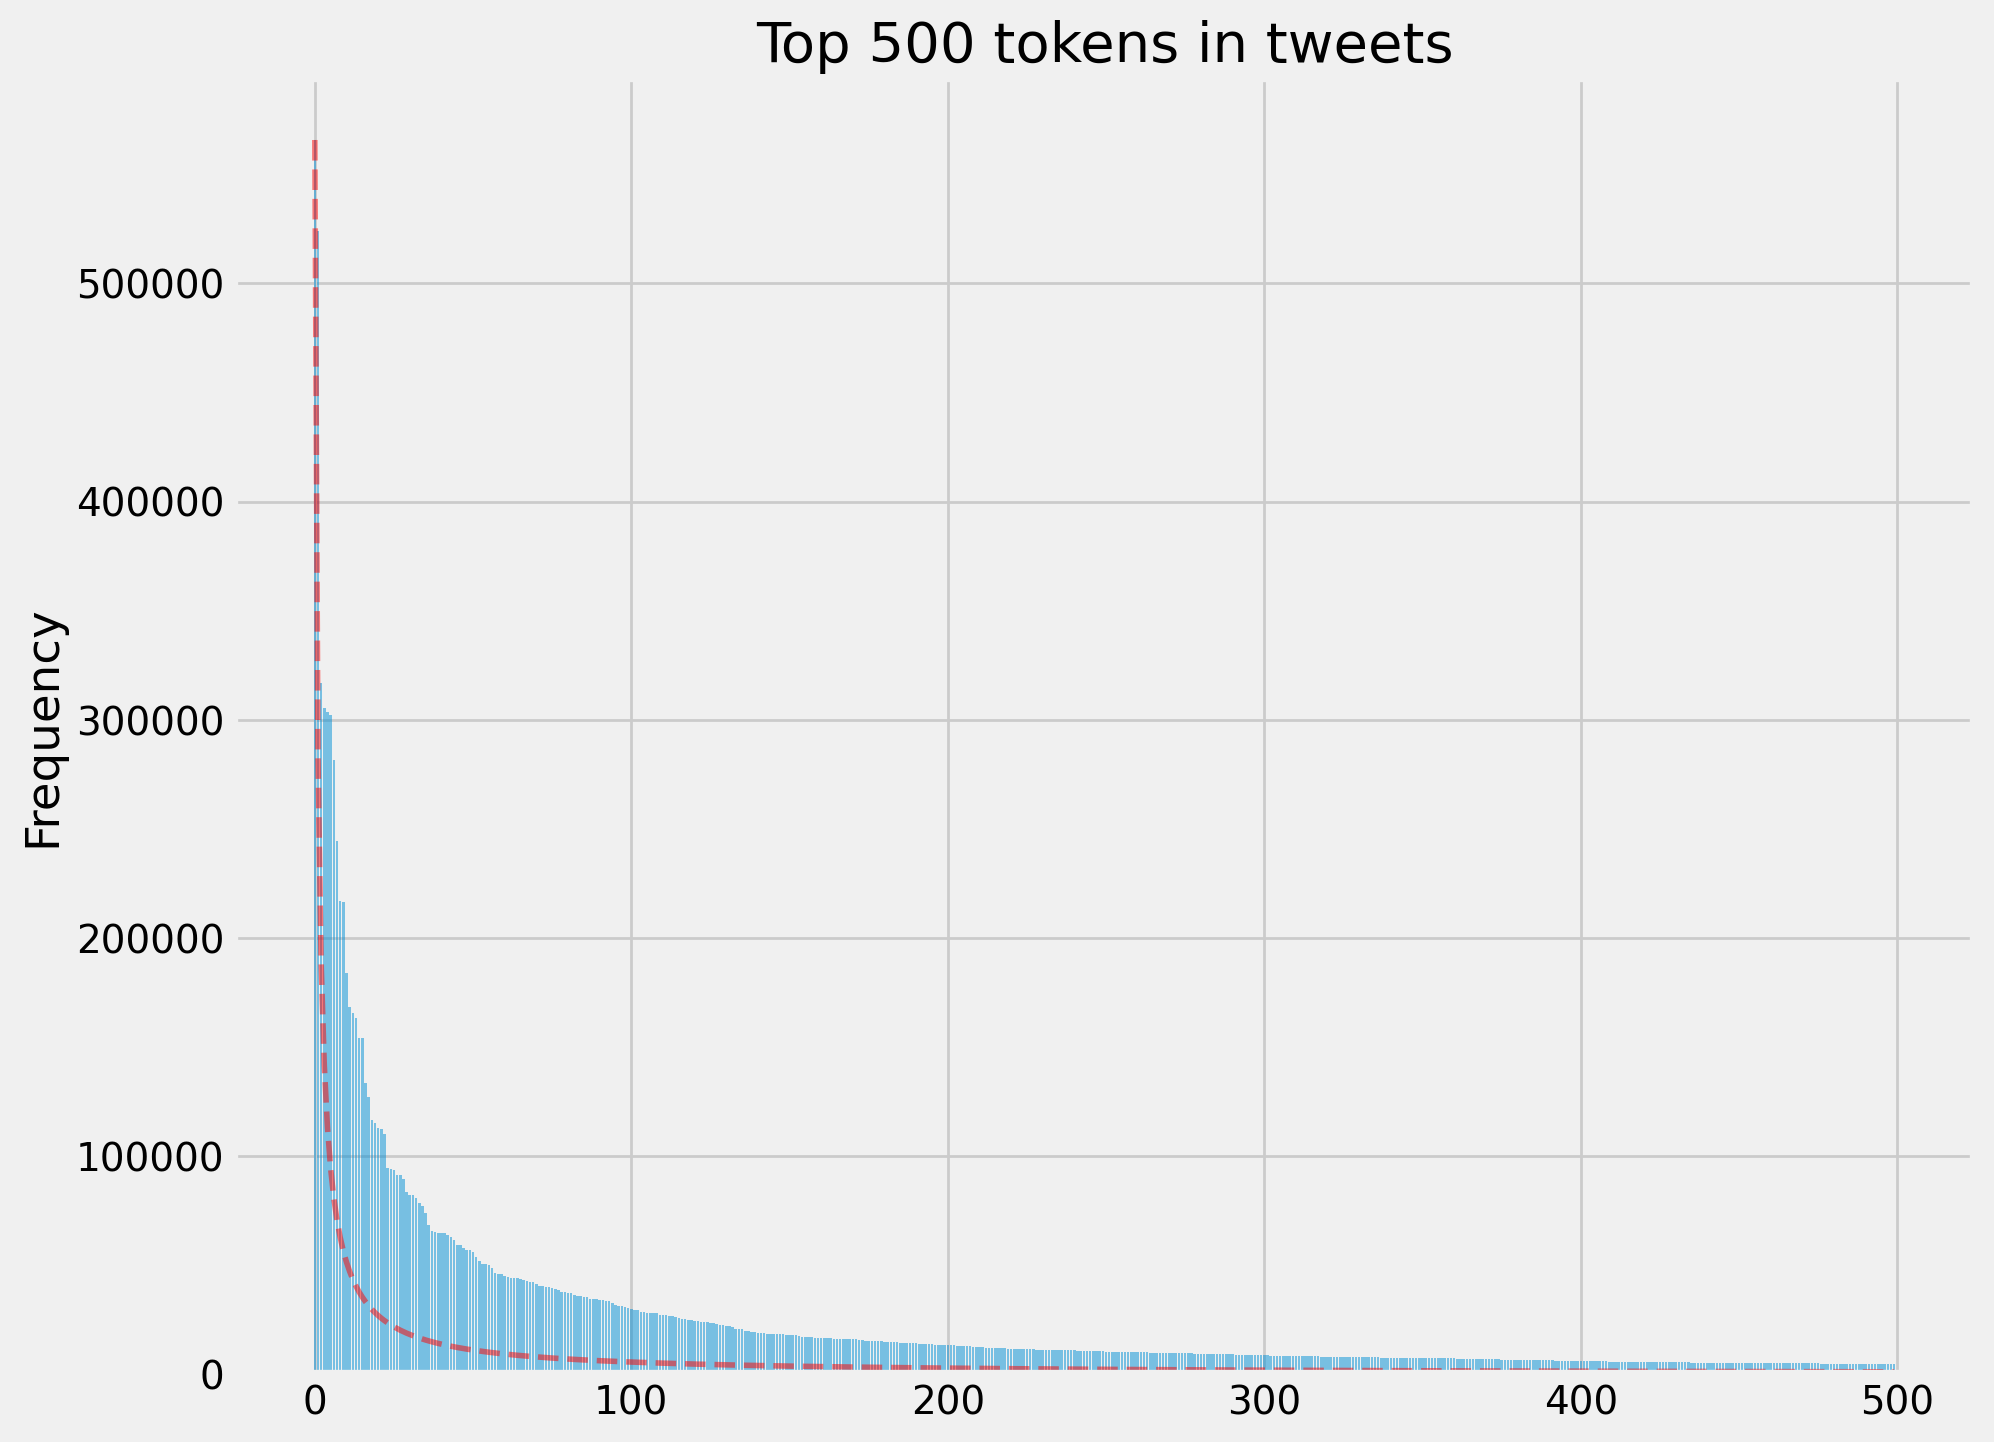

In [24]:
# Zipf's Law verification
# Attempt to verify Zip's law by graphing ranked words frequency. Observation shows. It is not perfectly Zipf.
# However it has a similar following to the graph.
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')

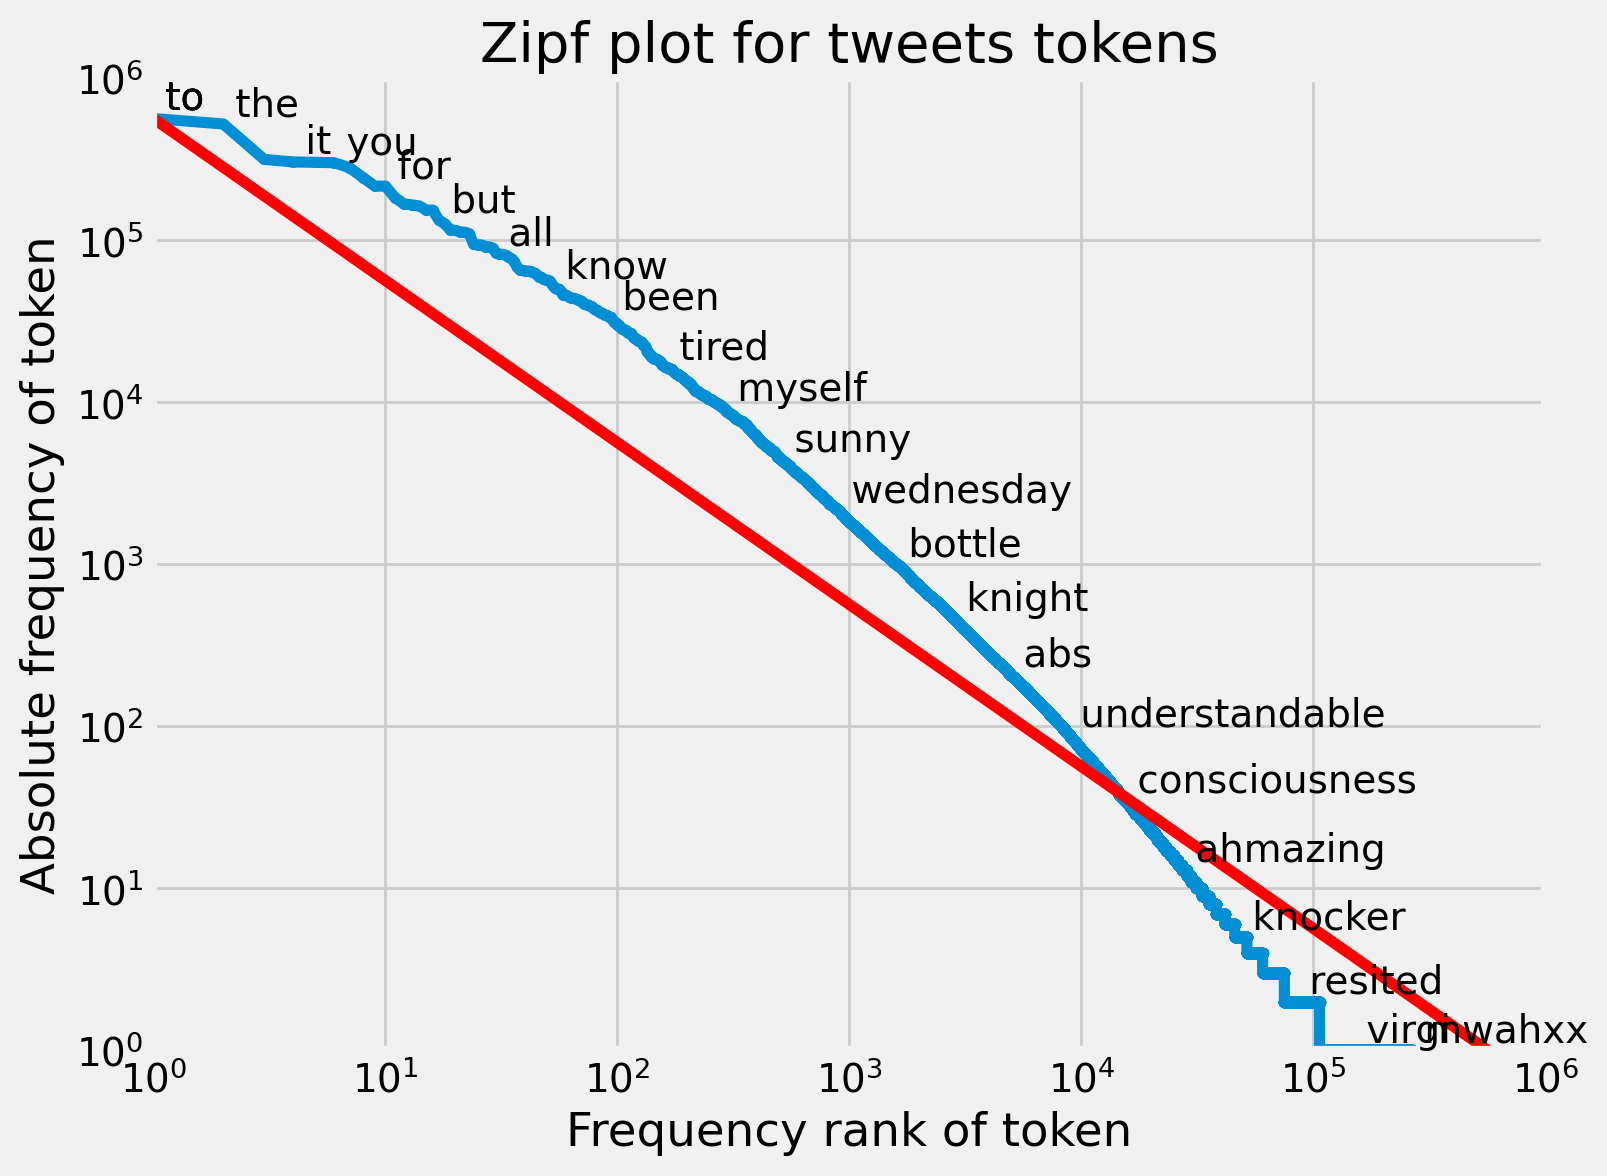

In [25]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

In [ ]:
# What if we want to determine which words are best representative
# of a positive tweet and a negative tweet?

In [ ]:
# We need to remove words that are commonly occuring in both types
# of tweets, aka stop words such as "and", "the", "a", "it"

In [27]:
# Perform a similar process as before counting the positive and negative terms,
# and only performing for 10,000 tweets, rather than 1,600,000
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english',max_features=10000)
cvec.fit(my_df.text)
document_matrix = cvec.transform(my_df.text)

neg_doc_matrix = cvec.transform(my_df[my_df.target == 0].text) # negative
pos_doc_matrix = cvec.transform(my_df[my_df.target == 4].text) # positive
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names_out()).transpose()

term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
just,64004,62944,126948
good,29209,62118,91327
day,41374,48186,89560
like,41050,37520,78570
today,38116,30100,68216
work,45420,19529,64949
love,16990,47694,64684
going,33689,30939,64628
got,33408,28037,61445
lol,23123,36118,59241


Text(0.5, 1.0, 'Top 50 tokens in Positive tweets')

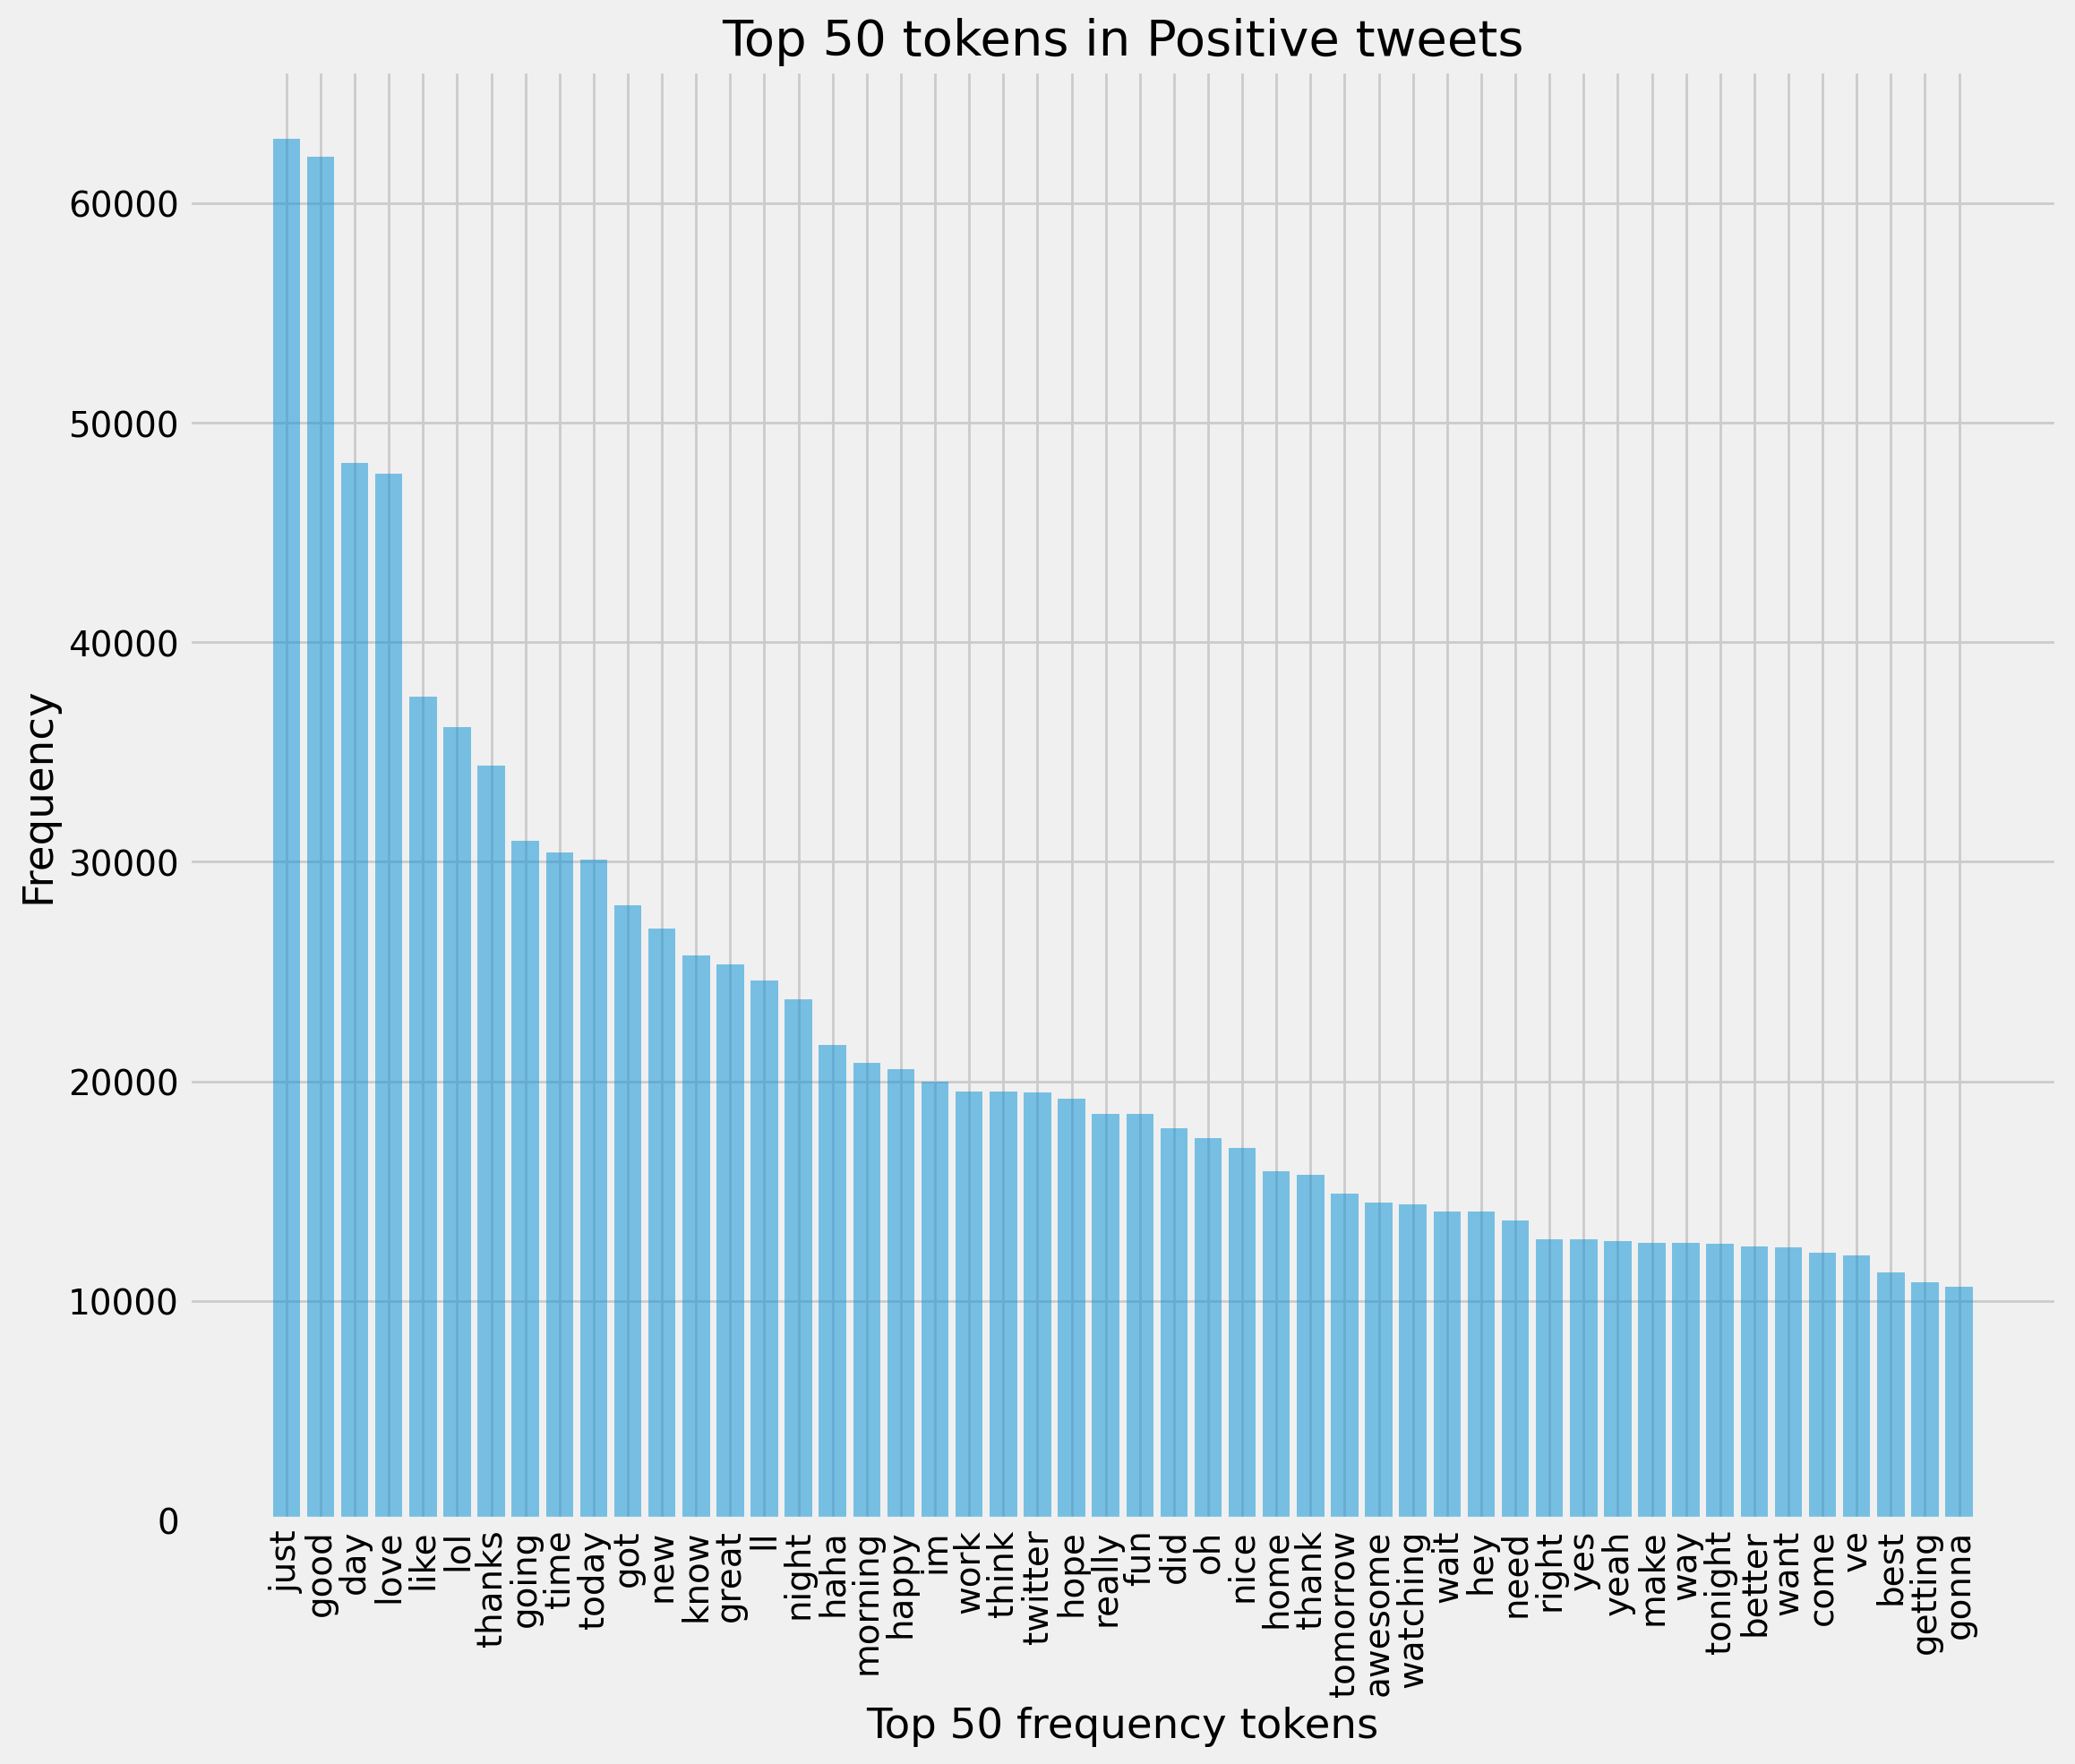

In [28]:
# Plot top 50 tokens in positive tweets
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by="positive", ascending=False)["positive"][:50], align="center", alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by="positive", ascending=False)["positive"][:50].index, rotation="vertical") 
plt.ylabel("Frequency")
plt.xlabel("Top 50 frequency tokens")
plt.title("Top 50 tokens in Positive tweets")

Text(0.5, 1.0, 'Top 50 tokens in Negative tweets')

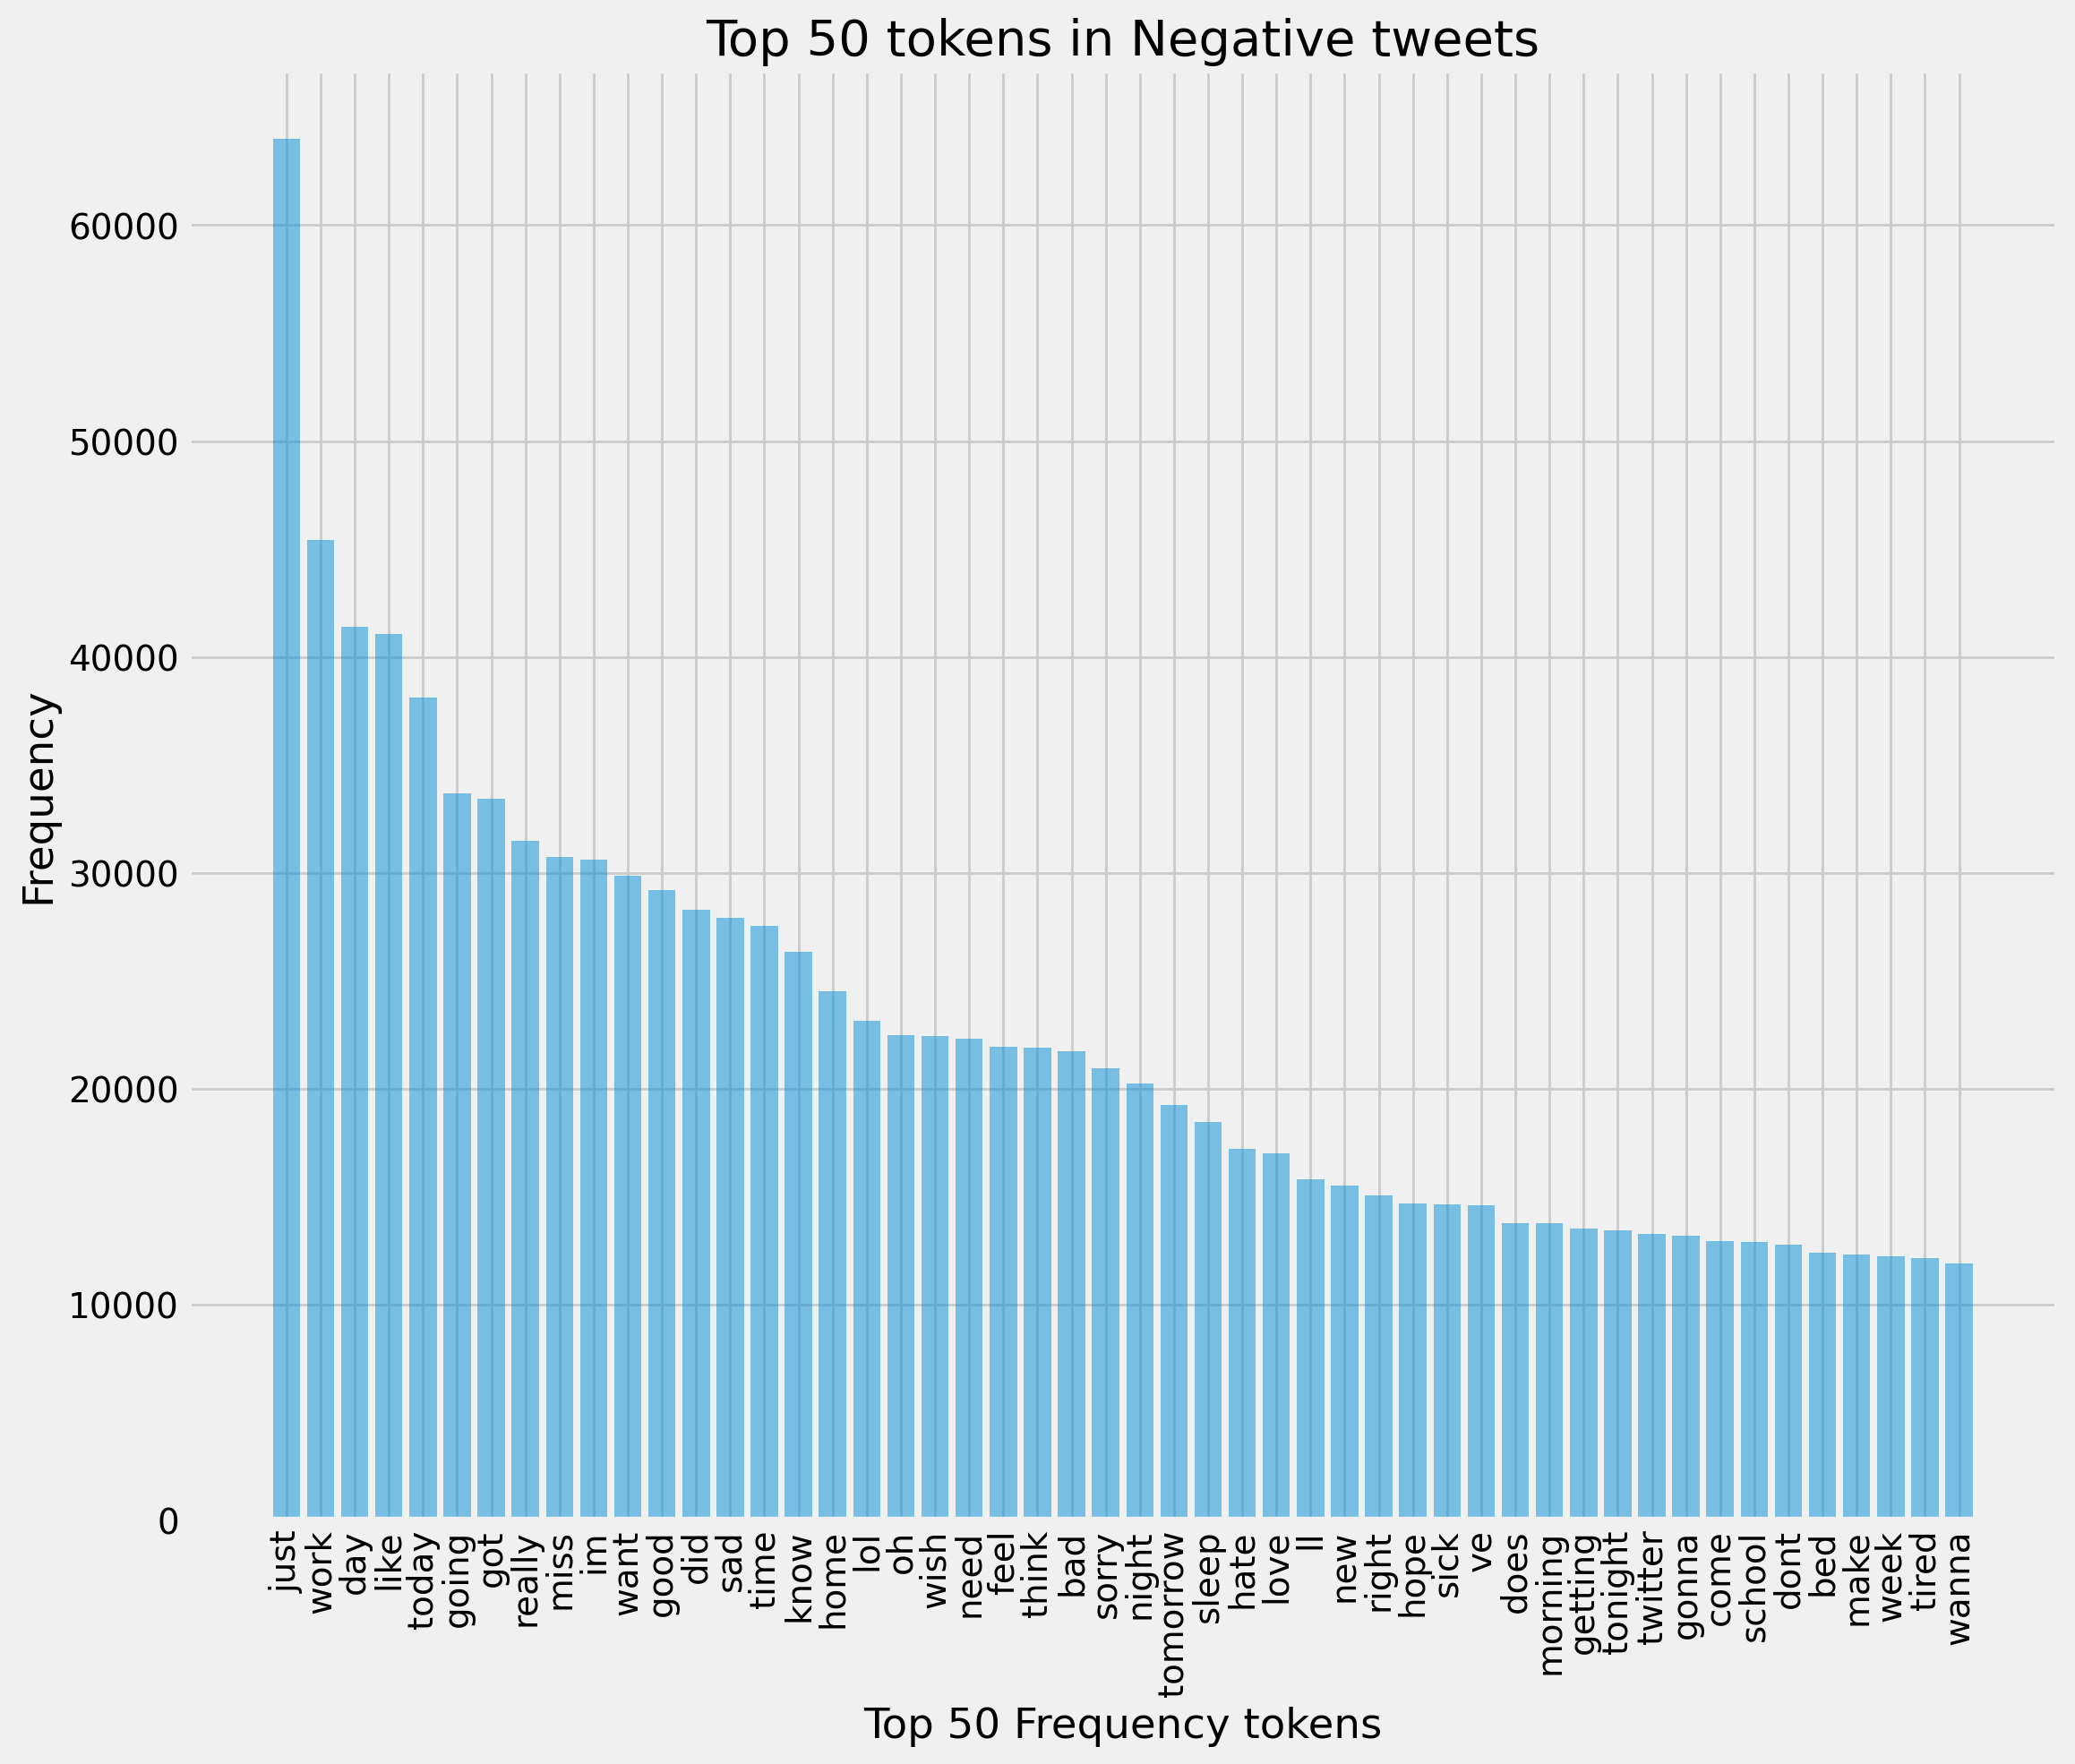

In [29]:
# Plot top 50 words in negative tweets
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)
       ['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)
       ['negative'][:50].index, rotation='vertical')
plt.ylabel("Frequency")
plt.xlabel("Top 50 Frequency tokens")
plt.title("Top 50 tokens in Negative tweets")

In [30]:
# isolate which words are more important to a positive tweet 
# than a negative tweet by if a token appears in a positive tweet 
# much more than a negative tweet, vice versa.

# Formula pos_rate = positive freq/(positive freq + negative freq)
# Higher pos_rate means lower frequency of a token in negative tweets
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='pos_rate', ascending=False).iloc[:10]

,negative,positive,total,pos_rate
emailunlimited,0,100,100,1.000000
dividends,0,83,83,1.000000
mileymonday,0,161,161,1.000000
shareholder,1,80,81,0.987654
fuzzball,2,99,101,0.980198
recommends,3,109,112,0.973214
delongeday,6,162,168,0.964286
atcha,3,80,83,0.963855
timestamp,3,68,71,0.957746
shaundiviney,4,89,93,0.956989


In [32]:
# Metric is showing very obscure words. Generate more common words 
# by determining frequency of pos_rate ranked words among positive tweets.

# Equation pos_freq_pct = positive freq/ sum(positive freq). This metric
# should show how often a high pos_rate word occurs in the postive category
# which should be more indicative if a word defines a positive tweet.
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()

# Putting together pos_freq_pct and pos_rate, we can conclude a harmonic mean
# which will accurate create a ranking of  tokens representing pos. tweets

from scipy.stats import hmean
term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['pos_rate'], x["pos_freq_pct"]])
                                                if x["pos_rate"] > 0 and x["pos_freq_pct"] > 0 else 0), axis = 1)

# Conduct a similar analysis on negative tweets
term_freq_df2['neg_rate'] = term_freq_df2['negative'] * 1./term_freq_df2['total']
term_freq_df2['neg_freq_pct'] = term_freq_df2['negative'] * 1./term_freq_df2['negative'].sum()
term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])                                                                if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0                                                                else 0), axis=1)
                                                       
term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,neg_rate,neg_freq_pct,neg_hmean
just,64004,62944,126948,0.495825,0.014396,0.027980,0.504175,0.013979,0.027203
good,29209,62118,91327,0.680171,0.014207,0.027833,0.319829,0.006379,0.012509
day,41374,48186,89560,0.538030,0.011021,0.021599,0.461970,0.009036,0.017726
love,16990,47694,64684,0.737338,0.010908,0.021498,0.262662,0.003711,0.007318
like,41050,37520,78570,0.477536,0.008581,0.016860,0.522464,0.008965,0.017628
lol,23123,36118,59241,0.609679,0.008261,0.016300,0.390321,0.005050,0.009971
thanks,5768,34375,40143,0.856314,0.007862,0.015581,0.143686,0.001260,0.002498
going,33689,30939,64628,0.478724,0.007076,0.013946,0.521276,0.007358,0.014511
time,27526,30432,57958,0.525070,0.006960,0.013738,0.474930,0.006012,0.011873
today,38116,30100,68216,0.441245,0.006884,0.013557,0.558755,0.008325,0.016405


In [33]:
# I believed that using the harmonic mean would help elevate the effect of 
# the pos_freq_pct, and reduce impact of pos_rate, but the aggravation of
# pos_freq_pct is too much, and a similar ranking to pos_freq_pct is reached.

# Attempt at using a Cumulative Distribution Function CDF
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

In [34]:
# Positive CDF
term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])
term_freq_df2['pos_hmean_normcdf'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])

# Negative CDF
term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])
term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])
term_freq_df2['neg_hmean_normcdf'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])

term_freq_df2.sort_values(by='neg_hmean_normcdf', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,neg_rate,neg_freq_pct,neg_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_hmean_normcdf,neg_rate_normcdf,neg_freq_pct_normcdf,neg_hmean_normcdf
sad,27911,1510,29421,0.051324,0.000345,0.000686,0.948676,0.006096,0.012114,0.002393,0.709591,0.004771,0.997607,1.000000,0.998802
hurts,7204,456,7660,0.059530,0.000104,0.000208,0.940470,0.001573,0.003141,0.002808,0.503854,0.005586,0.997192,0.999742,0.998465
sick,14617,1419,16036,0.088488,0.000325,0.000647,0.911512,0.003192,0.006362,0.004842,0.693343,0.009616,0.995158,1.000000,0.997573
sucks,9902,982,10884,0.090224,0.000225,0.000448,0.909776,0.002163,0.004315,0.004997,0.610419,0.009914,0.995003,0.999999,0.997495
poor,7333,719,8052,0.089295,0.000164,0.000328,0.910705,0.001602,0.003197,0.004913,0.557659,0.009741,0.995087,0.999799,0.997437
ugh,9056,998,10054,0.099264,0.000228,0.000455,0.900736,0.001978,0.003947,0.005883,0.613574,0.011655,0.994117,0.999995,0.997047
missing,7282,991,8273,0.119787,0.000227,0.000452,0.880213,0.001590,0.003175,0.008429,0.612194,0.016630,0.991571,0.999778,0.995658
headache,5317,421,5738,0.073371,0.000096,0.000192,0.926629,0.001161,0.002320,0.003657,0.496667,0.007261,0.996343,0.993811,0.995075
hate,17207,2614,19821,0.131880,0.000598,0.001190,0.868120,0.003758,0.007484,0.010345,0.868740,0.020446,0.989655,1.000000,0.994801
miss,30713,5676,36389,0.155981,0.001298,0.002575,0.844019,0.006708,0.013310,0.015318,0.996497,0.030171,0.984682,1.000000,0.992282


In [ ]:
# Looking at the pos_hmean_normcdf and neg_hmean_normcdf, these
# are the indicators that a word will be associated with a positive or
# negative tweet.
# A higher pos_hmean_normcdf means a word is closely tied to positive.
# Similar logic can be applied to neg_hmean_normcdf

In [35]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool
output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df2.pos_hmean_normcdf), high=max(term_freq_df2.pos_hmean_normcdf))
p = figure(x_axis_label='neg_hmean_normcdf', y_axis_label='pos_hmean_normcdf')
p.circle('neg_hmean_normcdf','pos_hmean_normcdf',size=5,alpha=0.3,source=term_freq_df2,color={'field': 'pos_hmean_normcdf', 'transform': color_mapper})
hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

Loading BokehJS ...